In [ ]:
pip install plotly

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

In [11]:
# Load the dataset (assuming it's uploaded to the environment)
data = pd.read_csv("/content/btcusd_1-min_data (1).csv")
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data.set_index('Timestamp', inplace=True)

data.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [12]:
daily_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].resample('D').agg({
    'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'
}).dropna()

In [13]:
daily_data.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742


In [14]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4917 entries, 2012-01-01 to 2025-06-17
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4917 non-null   float64
 1   High    4917 non-null   float64
 2   Low     4917 non-null   float64
 3   Close   4917 non-null   float64
 4   Volume  4917 non-null   float64
dtypes: float64(5)
memory usage: 230.5 KB


In [15]:
# ambil data dari 2025 aja
daily_data = daily_data.loc['2025-01-01':]


In [16]:
daily_data.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-01-01,93347.0,94951.0,92768.0,94388.0,777.139425
2025-01-02,94380.0,97745.0,94205.0,96907.0,1219.193707
2025-01-03,96895.0,98951.0,96042.0,98133.0,1159.419098
2025-01-04,98133.0,98753.0,97540.0,98209.0,445.491303
2025-01-05,98218.0,98799.0,97277.0,98327.0,454.720192


# LSTM

In [17]:
# Remove the line that filters data from 2025 onwards
# daily_data = daily_data.loc['2025-01-01':]

# Normalize the data
# Add a check to see if daily_data is empty before normalization
if daily_data.empty:
    print("Error: daily_data is empty before normalization. Please check data loading and initial processing steps.")
else:
    scaler = MinMaxScaler()
    # Use only the 'Close' price for scaling if you are building an LSTM for univariate time series
    # If you want to use all columns, the reshape should be (-1, daily_data.shape[1])
    # However, your create_sequences function and LSTM input shape (..., 1)
    # suggest you intend to use a single feature, likely 'Close'.
    # Let's scale only the 'Close' column as it seems to be the target.
    scaled_data = scaler.fit_transform(daily_data['Close'].values.reshape(-1, 1))


    # Continue with creating sequences and training the model if data exists
    # Create sequences for LSTM (30-day lookback, based on your seq_length definition later)
    seq_length = 30
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    # Ensure there's enough data for the sequence length
    if len(scaled_data) >= seq_length:
        X, y = create_sequences(scaled_data, seq_length)

        # Split into train and test sets (80-20 split)
        train_size = int(len(X) * 0.8)
        # Ensure train set is not empty and test set has at least one sample
        if train_size > 0 and len(X) - train_size > 0:
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
            print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        else:
             print("Warning: Not enough data after creating sequences to create a non-empty training and test set.")

    else:
        print(f"Warning: Not enough data ({len(scaled_data)} samples) to create sequences of length {seq_length}.")

X_train shape: (110, 30, 1), y_train shape: (110, 1)
X_test shape: (28, 30, 1), y_test shape: (28, 1)


In [18]:
# Create sequences for LSTM (60-day lookback)
seq_length = 30
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length)

In [19]:
# Split into train and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (110, 30, 1), y_train shape: (110, 1)
X_test shape: (28, 30, 1), y_test shape: (28, 1)


## EDA

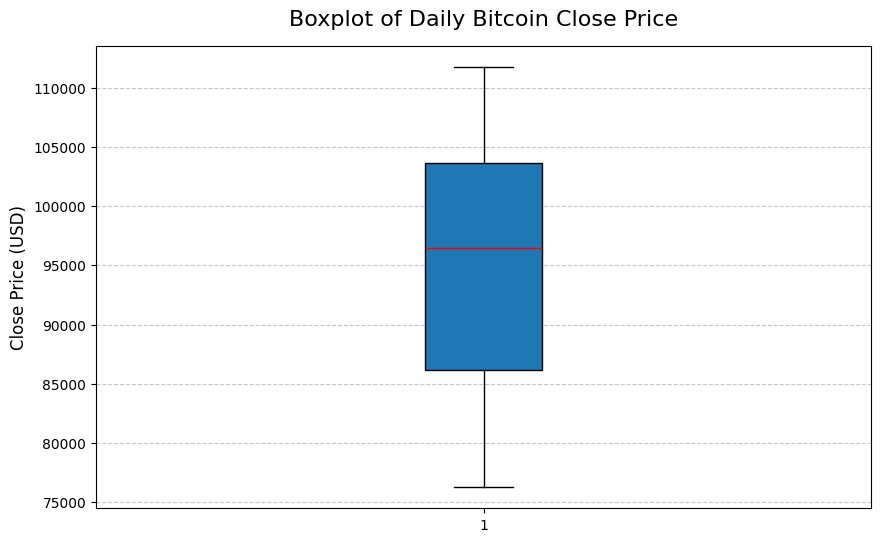

In [20]:
# boxplot daily data close
plt.figure(figsize=(10, 6))
plt.boxplot(daily_data['Close'].dropna(), patch_artist=True, medianprops={'color': 'red'})
plt.title('Boxplot of Daily Bitcoin Close Price', fontsize=16, pad=15)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


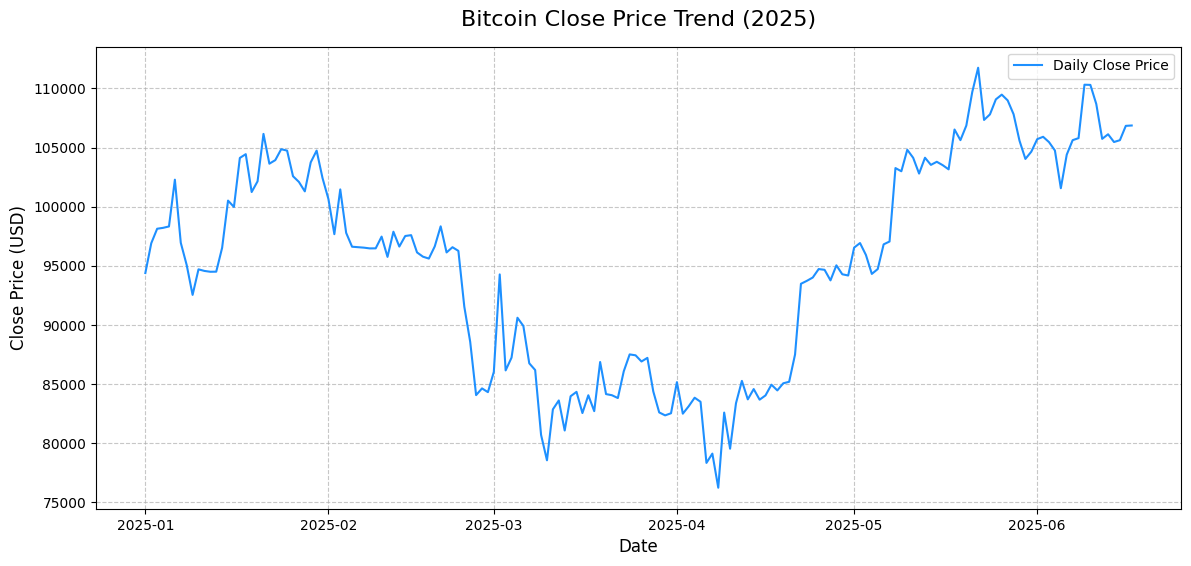

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Close'], label='Daily Close Price', color='#1E90FF')
plt.title('Bitcoin Close Price Trend (2025)', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

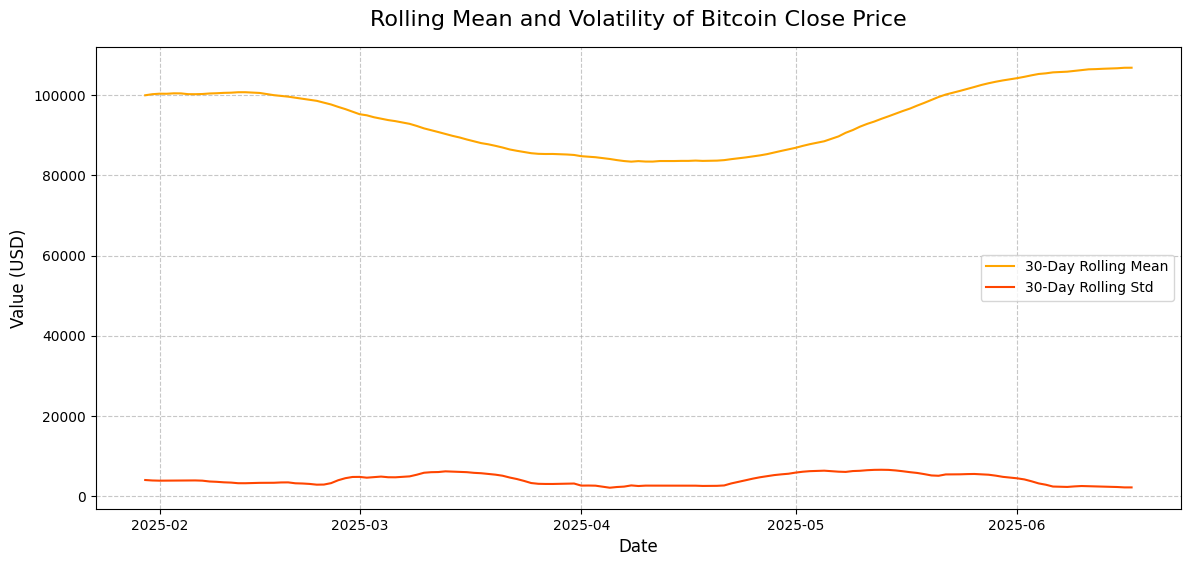

In [22]:
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Close'].rolling(window=30).mean(), label='30-Day Rolling Mean', color='#FFA500')
plt.plot(daily_data.index, daily_data['Close'].rolling(window=30).std(), label='30-Day Rolling Std', color='#FF4500')
plt.title('Rolling Mean and Volatility of Bitcoin Close Price', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

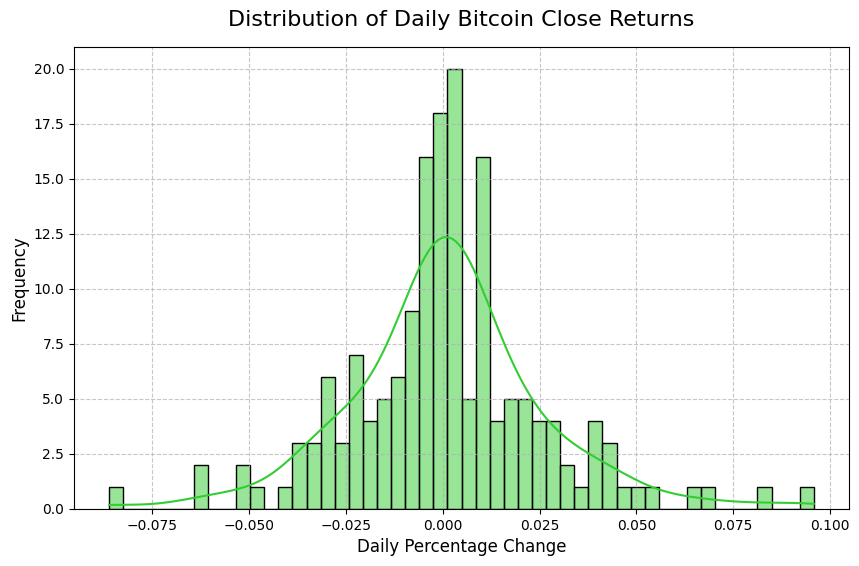

In [23]:
daily_returns = daily_data['Close'].pct_change().dropna()
plt.figure(figsize=(10, 6))
sns.histplot(daily_returns, bins=50, kde=True, color='#32CD32')
plt.title('Distribution of Daily Bitcoin Close Returns', fontsize=16, pad=15)
plt.xlabel('Daily Percentage Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [24]:
fig = go.Figure(data=[go.Candlestick(x=daily_data.index,
                                     open=daily_data['Open'],
                                     high=daily_data['High'],
                                     low=daily_data['Low'],
                                     close=daily_data['Close'],
                                     name='Candlestick')])

fig.add_trace(go.Bar(x=daily_data.index, y=daily_data['Volume'], name='Volume', yaxis='y2'))

fig.update_layout(
    title='Interactive Bitcoin Candlestick Chart with Volume (2025)',
    yaxis_title='Price (USD)',
    yaxis2=dict(title='Volume', overlaying='y', side='right'),
    xaxis_title='Date',
    template='plotly_dark',
    height=600
)

fig.show()

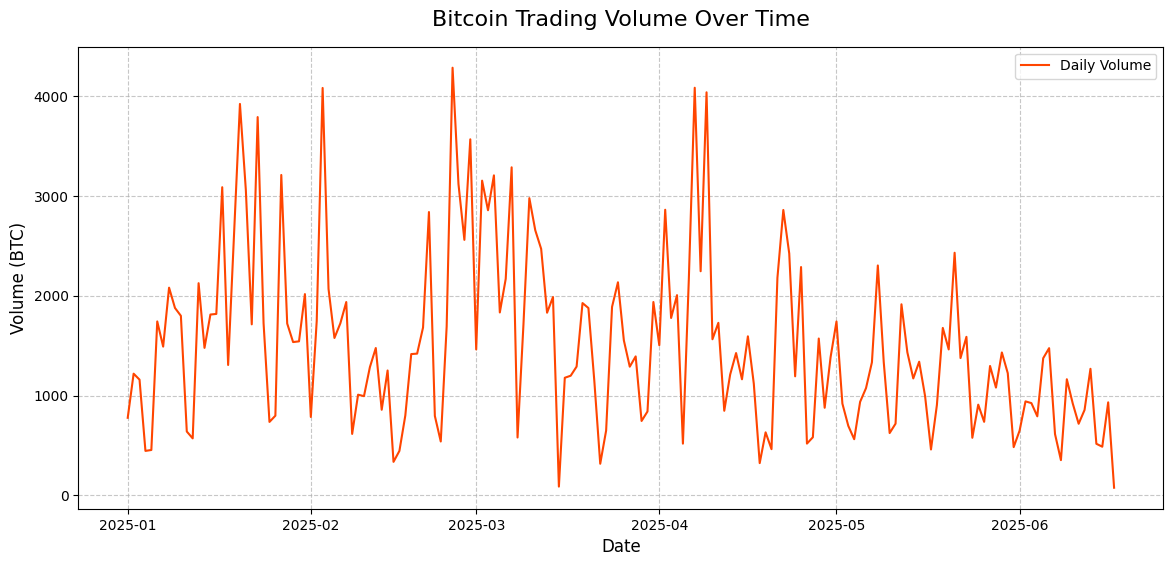

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Volume'], label='Daily Volume', color='#FF4500')
plt.title('Bitcoin Trading Volume Over Time', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume (BTC)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

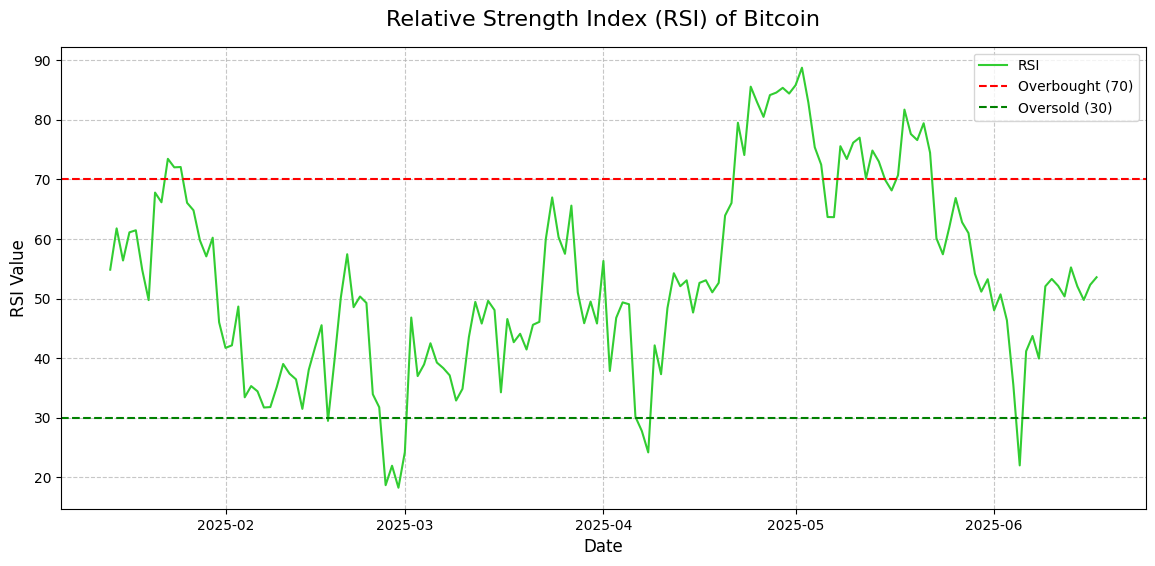

In [26]:
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))

rsi = calculate_rsi(daily_data['Close'])
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index[-len(rsi):], rsi, label='RSI', color='#32CD32')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI) of Bitcoin', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('RSI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

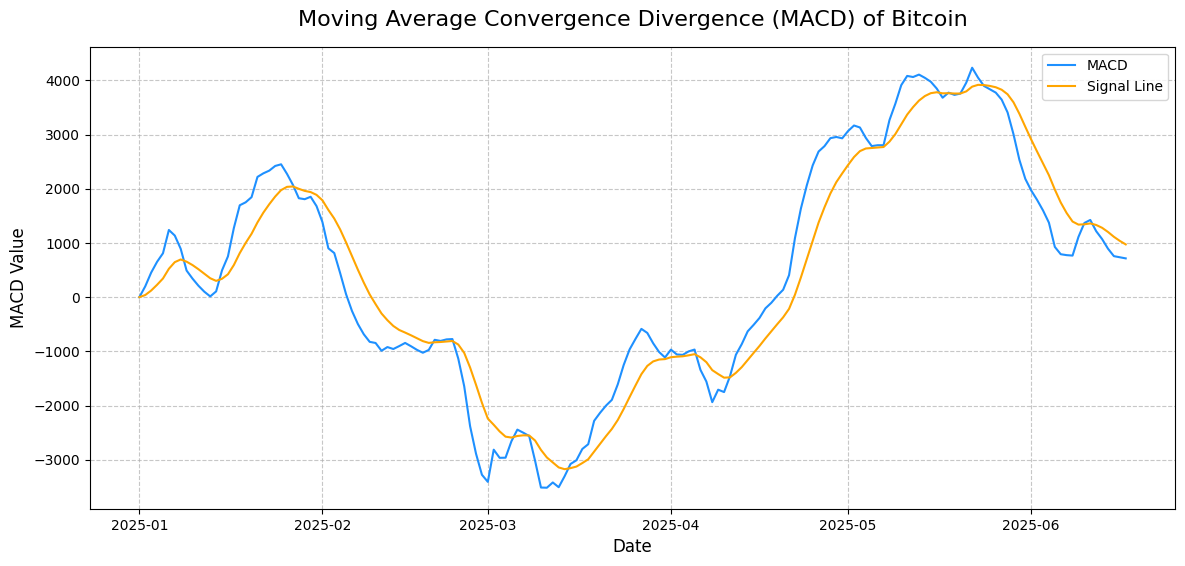

In [27]:
def calculate_macd(data, slow=26, fast=12, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

macd, signal_line = calculate_macd(daily_data['Close'])
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index[-len(macd):], macd, label='MACD', color='#1E90FF')
plt.plot(daily_data.index[-len(signal_line):], signal_line, label='Signal Line', color='#FFA500')
plt.title('Moving Average Convergence Divergence (MACD) of Bitcoin', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('MACD Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## MODELLING LSTM

In [28]:
# Build the LSTM model
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(seq_length, 1), activation='tanh'),
    Dropout(0.3),
    LSTM(units=50, return_sequences=False, activation='tanh'),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1,
                    callbacks=[early_stopping], verbose=1)

# Save training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - loss: 0.1293 - val_loss: 0.1099
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0219 - val_loss: 0.0106
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0233 - val_loss: 0.0972
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0203 - val_loss: 0.0955
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0195 - val_loss: 0.0312
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0196 - val_loss: 0.0323
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0157 - val_loss: 0.0765
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0193 - val_loss: 0.0821
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0144 - val_loss: 0.0475
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0134 - val_loss: 0.0171
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0158 - val_loss: 0.0248
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0160 - val_loss: 0.0408


## MODEL EVALUATION

#### Training and Validation Loss Plot

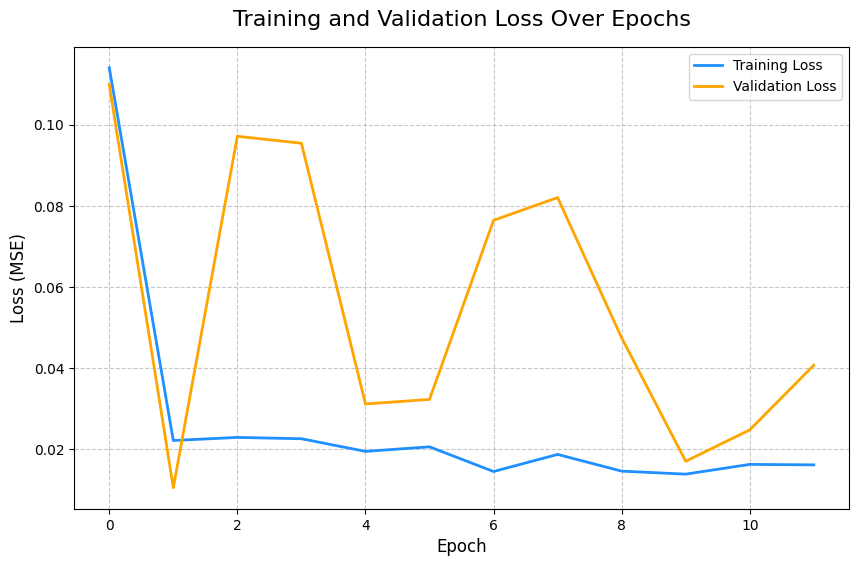

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='#1E90FF', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='#FFA500', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Prediction Error Metrics

In [31]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
Root Mean Squared Error (RMSE): 2952.58
Mean Absolute Error (MAE): 2524.85


#### Prediction and Visualization

In [32]:
test_dates = daily_data.index[-len(y_test_inv):]
predicted_prices = y_pred.flatten()
actual_prices = y_test_inv.flatten()

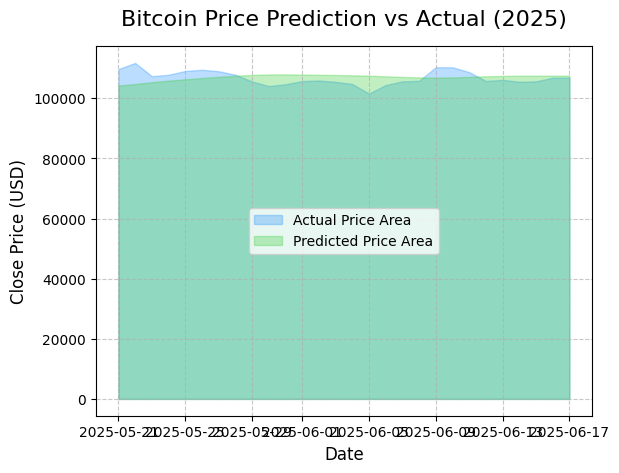

In [33]:
# Plot actual prices with area fill
plt.fill_between(test_dates, actual_prices, color='#1E90FF', alpha=0.3, label='Actual Price Area')
# plt.plot(test_dates, actual_prices, color='#1E90FF', linewidth=2, label='Actual Price')

# Plot predicted prices with area fill
plt.fill_between(test_dates, predicted_prices, color='#32CD32', alpha=0.3, label='Predicted Price Area')
# plt.plot(test_dates, predicted_prices, color='#32CD32', linewidth=2, label='Predicted Price')

plt.title('Bitcoin Price Prediction vs Actual (2025)', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [34]:
# Save the model
model.save('bitcoin_lstm_model.h5')
print("Model saved as 'bitcoin_lstm_model.h5'")

Model saved as 'bitcoin_lstm_model.h5'


#### Prediction (Next 3 days)

In [36]:
# Get the last sequence from the training data
last_sequence = scaled_data[-seq_length:].reshape((1, seq_length, 1))

# Generate predictions for the next 3 days
future_predictions = []
n_future = 3

current_sequence = last_sequence.copy()
for _ in range(n_future):
    next_pred = model.predict(current_sequence)
    future_predictions.append(next_pred[0, 0])
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_pred[0, 0]

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame with predicted dates and prices
last_date = daily_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D')
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close_Price_USD': future_predictions.flatten()
})

# Display the DataFrame
print("\nPredicted Bitcoin Close Prices for the Next 3 Days:")
print(future_df.to_string(index=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Predicted Bitcoin Close Prices for the Next 3 Days:
      Date  Predicted_Close_Price_USD
2025-06-18              107519.929688
2025-06-19              107560.789062
2025-06-20              107616.625000


# ARIMA

Text(0, 0.5, 'Close Price (USD)')

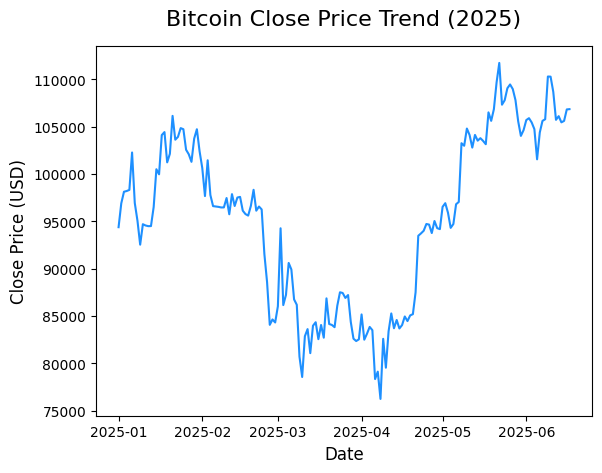

In [37]:
# plot data daily
plt.plot(daily_data['Close'], label='Close Price', color='#1E90FF')
plt.title('Bitcoin Close Price Trend (2025)', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)

In [38]:
# test stasioner data
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_data['Close'])

# Cetak hasil
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -1.1561504557586721
p-value: 0.6921687292576179
Critical Values:
   1%: -3.4703698981001665
   5%: -2.8791138497902193
   10%: -2.576139407751488


## Transformasi Data dengan differences

In [39]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

def ndiffs_adf(series, alpha=0.05, max_d=2):
    d = 0
    p_value = adfuller(np.log(series.dropna()))[1]

    while p_value > alpha and d < max_d:
        d += 1
        series = series.diff().dropna()
        p_value = adfuller(series)[1]

    return d

In [40]:
import pandas as pd
data_close = daily_data['Close']
nd = ndiffs_adf(data_close)
print("Number of differences needed:", nd)

Number of differences needed: 1


ADF Test - Diff 1 (tanpa log)
ADF Statistic: -14.873316136438122
p-value: 1.650766176907416e-27
Critical Values: {'1%': np.float64(-3.4703698981001665), '5%': np.float64(-2.8791138497902193), '10%': np.float64(-2.576139407751488)}


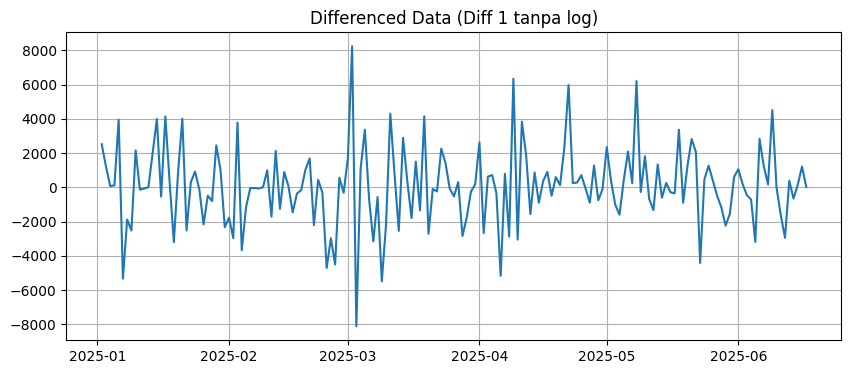

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# --- Diff 1 (tanpa log) ---
ddif1 = data_close.diff().dropna()

# ADF Test
result_ddif1 = adfuller(ddif1)
print("ADF Test - Diff 1 (tanpa log)")
print(f"ADF Statistic: {result_ddif1[0]}")
print(f"p-value: {result_ddif1[1]}")
print("Critical Values:", result_ddif1[4])

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ddif1)
plt.title("Differenced Data (Diff 1 tanpa log)")
plt.grid(True)
plt.show()



ADF Test - Diff 1 (dengan log)
ADF Statistic: -15.123478348517729
p-value: 7.4031111687137675e-28
Critical Values: {'1%': np.float64(-3.4703698981001665), '5%': np.float64(-2.8791138497902193), '10%': np.float64(-2.576139407751488)}


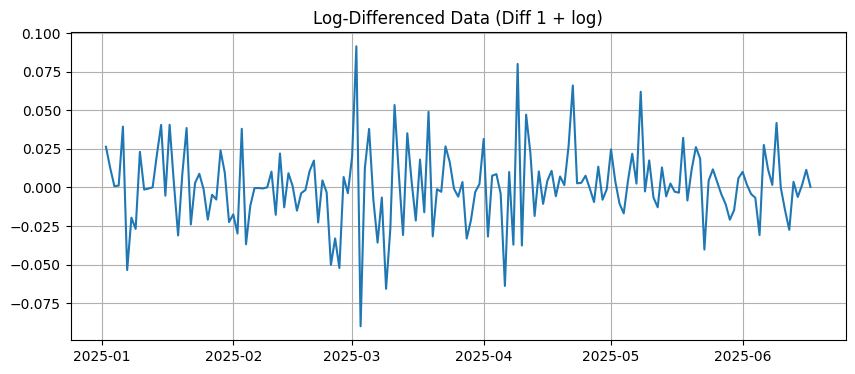

In [42]:

# --- Diff 1 dengan Log ---
dtrans1 = np.log(data_close).diff().dropna()

# ADF Test
result_dtrans1 = adfuller(dtrans1)
print("\nADF Test - Diff 1 (dengan log)")
print(f"ADF Statistic: {result_dtrans1[0]}")
print(f"p-value: {result_dtrans1[1]}")
print("Critical Values:", result_dtrans1[4])

# Plot
plt.figure(figsize=(10, 4))
plt.plot(dtrans1)
plt.title("Log-Differenced Data (Diff 1 + log)")
plt.grid(True)
plt.show()


<Figure size 800x400 with 0 Axes>

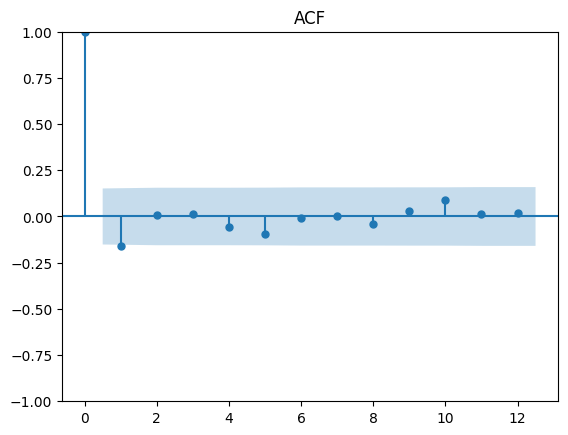

<Figure size 800x400 with 0 Axes>

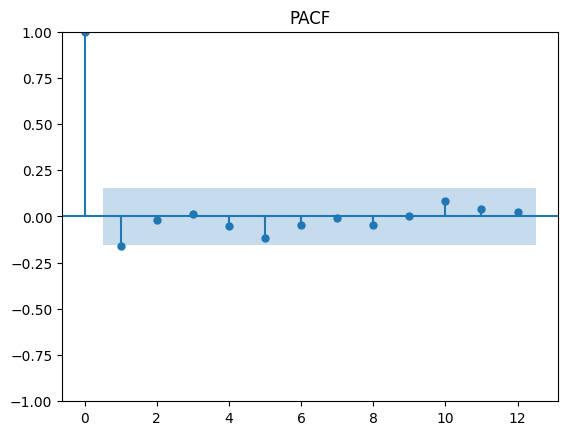

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF
plt.figure(figsize=(8, 4))
plot_acf(dtrans1, lags=12, alpha=0.05, title="ACF")  # alpha = 0.05 → 95% CI
plt.show()

# PACF
plt.figure(figsize=(8, 4))
plot_pacf(dtrans1, lags=12, alpha=0.05, method='ywm', title="PACF")
plt.show()



## Modelling

In [44]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from scipy.special import boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox

def loopin_arima(data, max_p, max_q, d=1, include_constant=False, lambda_=None):
    if isinstance(data, pd.Series) == False:
        data = pd.Series(data)

    # Transformasi Box-Cox jika lambda diberikan
    if lambda_ is not None:
        if lambda_ == 0:
            data = np.log(data)
        else:
            data, _ = boxcox(data, lmbda=lambda_)

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if not (p == 0 and q == 0):
                model_name = f"ARIMA({p},{d},{q})"
                print(f"\n===== Uji Hipotesis {model_name} =====")
                try:
                    model = ARIMA(data, order=(p, d, q), trend='n' if not include_constant else 'c')
                    result = model.fit()

                    print(result.summary().tables[1])  # Tabel koefisien seperti coeftest

                except Exception as e:
                    print(f"Model gagal diproses: {e}")

In [45]:
loopin_arima(data_close, max_p=4, max_q=4, d=1, include_constant=False, lambda_=0)


===== Uji Hipotesis ARIMA(0,1,1) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1636      0.056     -2.928      0.003      -0.273      -0.054
sigma2         0.0006   4.93e-05     12.518      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(0,1,2) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1557      0.061     -2.571      0.010      -0.274      -0.037
ma.L2          0.0060      0.076      0.078      0.938      -0.144       0.156
sigma2         0.0006   4.96e-05     12.458      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(0,1,3) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1      

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1609      0.060     -2.693      0.007      -0.278      -0.044
sigma2         0.0006   4.96e-05     12.447      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(1,1,1) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0456      0.458     -0.100      0.921      -0.942       0.851
ma.L1         -0.1186      0.440     -0.269      0.788      -0.982       0.744
sigma2         0.0006   4.96e-05     12.441      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(1,1,2) =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0814     13.366     -0.006      0.995     -26.277      26.115
ma.L1         -0.0829     13.380     -0.006      0.995     -26.307      26.141
ma.L2         -0.0075      2.209     -0.003      0.997      -4.338       4.323
sigma2         0.0006   4.99e-05     12.370      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(1,1,3) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6253      0.767      0.815      0.415      -0.878       2.129
ma.L1         -0.8003      0.796     -1.005      0.315      -2.360       0.760
ma.L2          0.1203      0.199      0.605      0.545      -0.270       0.510
ma.L3         -0.0509      0.073     -0.697      0.486      -0.194       0.092
sigma2      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0818    210.990     -0.000      1.000    -413.614     413.451
ar.L2         -0.0039      8.252     -0.000      1.000     -16.177      16.169
ma.L1         -0.0825    210.977     -0.000      1.000    -413.589     413.424
ma.L2         -0.0032     26.435     -0.000      1.000     -51.815      51.808
sigma2         0.0006    5.5e-05     11.237      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(2,1,3) =====


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4496      0.478      3.031      0.002       0.512       2.387
ar.L2         -0.6931      0.386     -1.795      0.073      -1.450       0.063
ma.L1         -1.6298      0.490     -3.329      0.001      -2.589      -0.670
ma.L2          0.9496      0.481      1.973      0.049       0.006       1.893
ma.L3         -0.1607      0.121     -1.324      0.185      -0.399       0.077
sigma2         0.0006    5.2e-05     11.626      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(2,1,4) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5531      0.499      1.109      0.268      -0.425       1.531
ar.L2         -0.4841      0.635     -0.763      0.445      -1.728       0.759
ma.L1       

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0819     25.304     -0.003      0.997     -49.676      49.512
ar.L2         -0.0032     12.340     -0.000      1.000     -24.190      24.183
ar.L3          0.0094      1.858      0.005      0.996      -3.632       3.651
ma.L1         -0.0822     25.276     -0.003      0.997     -49.622      49.458
ma.L2         -0.0034      8.457     -0.000      1.000     -16.578      16.571
sigma2         0.0006   5.56e-05     11.115      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(3,1,3) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8695      0.495      1.758      0.079      -0.100       1.839
ar.L2         -0.6626      0.724     -0.915      0.360      -2.082       0.756
ar.L3       

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6094      0.893      0.682      0.495      -1.142       2.360
ar.L2         -0.3852      1.210     -0.318      0.750      -2.758       1.987
ar.L3          0.0586      1.004      0.058      0.953      -1.909       2.026
ma.L1         -0.7608      0.896     -0.849      0.396      -2.518       0.996
ma.L2          0.4714      1.304      0.362      0.718      -2.083       3.026
ma.L3         -0.0962      1.184     -0.081      0.935      -2.417       2.225
ma.L4         -0.0850      0.214     -0.398      0.691      -0.504       0.334
sigma2         0.0006   5.48e-05     11.192      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(4,1,0) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3499      0.863      0.406      0.685      -1.341       2.041
ar.L2          0.1303      0.793      0.164      0.870      -1.424       1.684
ar.L3          0.0149      0.156      0.096      0.923      -0.290       0.320
ar.L4         -0.0890      0.086     -1.035      0.301      -0.257       0.079
ma.L1         -0.5219      0.885     -0.590      0.555      -2.255       1.212
ma.L2         -0.0634      0.904     -0.070      0.944      -1.835       1.709
sigma2         0.0006   5.49e-05     11.114      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(4,1,3) =====


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1121      0.459      2.422      0.015       0.212       2.012
ar.L2         -0.9696      0.456     -2.128      0.033      -1.863      -0.077
ar.L3          0.5889      0.403      1.462      0.144      -0.200       1.378
ar.L4          0.0835      0.113      0.739      0.460      -0.138       0.305
ma.L1         -1.2789      0.445     -2.876      0.004      -2.150      -0.407
ma.L2          1.1928      0.466      2.559      0.010       0.279       2.106
ma.L3         -0.7786      0.448     -1.737      0.082      -1.657       0.100
sigma2         0.0006    5.4e-05     11.309      0.000       0.001       0.001

===== Uji Hipotesis ARIMA(4,1,4) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Diagnostic Checking Model signfikan

Diagnostic Checking (MODEL YANG SIGNIFIKAN AJA)

**Uji Autokorelasi (BOX TEST RESIDUAL)**

H0: Tidak terjadi Autokorelasi pada residual

H1: Terjadi autokorelasi pada residual

ASUMSI TERPENUHI JIKA H0 TIDAK DITOLAK ATAU P-VALUE > 0.05

**Uji Homoskedastik (BOX TEST RESIDUAL^2)**

H0 : Residual bersifat homoskedastik

H1: Residual tidak bersifat homoskedastik

ASUMSI TERPENUHI JIKA H0 TIDAK DITOLAK ATAU P-VALUE > 0.05

**Uji Normalitas Residual (JARQUE.BERA.TEST)**

H0: Residual berdistribusi normal

H1: Residual tidak berdistribusi normal

ASUMSI TERPENUHI JIKA H0 TIDAK DITOLAK ATAU P-VALUE > 0.05

## Model ARIMA (0,1,1) no constant

In [46]:
# Fit model ARIMA(0,1,1) tanpa konstanta
log_data = np.log(data_close)
model1 = ARIMA(log_data, order=(0, 1, 1), trend='n')
fit1 = model1.fit()
print(fit1.summary())
resid1 = fit1.resid

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  168
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 380.027
Date:                Tue, 17 Jun 2025   AIC                           -756.054
Time:                        09:48:18   BIC                           -749.818
Sample:                    01-01-2025   HQIC                          -753.523
                         - 06-17-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1636      0.056     -2.928      0.003      -0.273      -0.054
sigma2         0.0006   4.93e-05     12.518      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

Ljung-Box Test (Autokorelasi Residual):
     lb_stat  lb_pvalue
10  0.009709        1.0

Ljung-Box Test (Autokorelasi pada residual^2):
     lb_stat  lb_pvalue
10  0.000087        1.0

Jarque-Bera Test (Normalitas Residual):
JB Statistic: 190008.2445, p-value: 0.0000


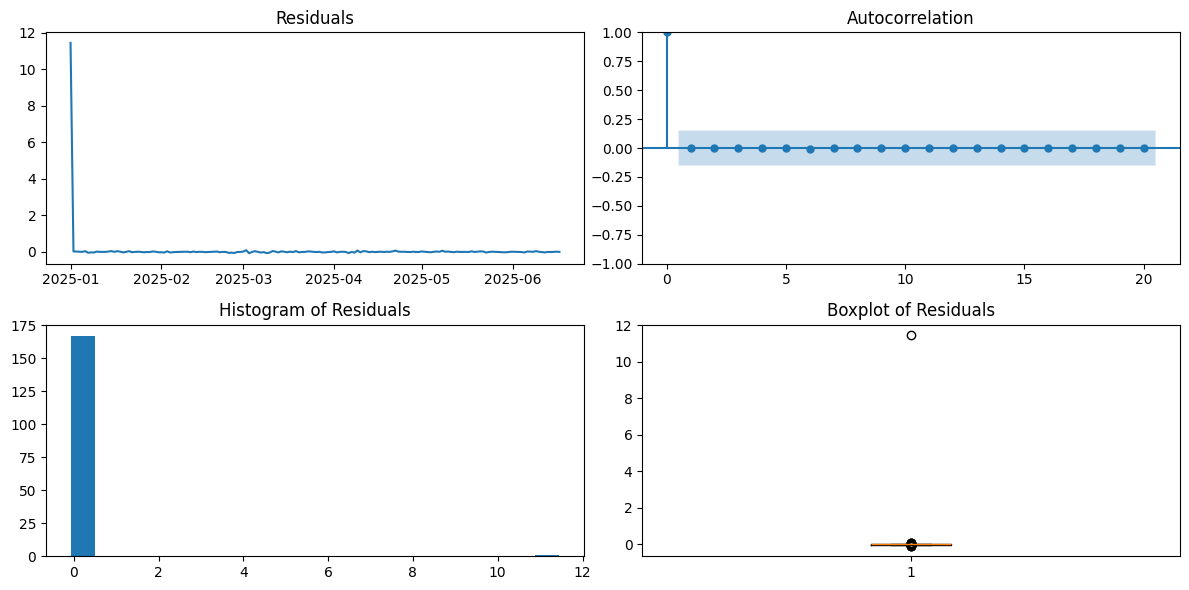

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- 1. Uji Autokorelasi (Ljung-Box Test) ---
print("Ljung-Box Test (Autokorelasi Residual):")
print(acorr_ljungbox(resid1, lags=[10], return_df=True))

# --- 2. Uji Homoskedastisitas (Ljung-Box kuadrat residual) ---
print("\nLjung-Box Test (Autokorelasi pada residual^2):")
print(acorr_ljungbox(resid1**2, lags=[10], return_df=True))

# --- 3. Uji Normalitas (Jarque-Bera) ---
print("\nJarque-Bera Test (Normalitas Residual):")
jb_stat, jb_pvalue = jarque_bera(resid1)
print(f"JB Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")

# --- 4. Plot Diagnostik ---
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(resid1)
plt.title("Residuals")

plt.subplot(2,2,2)
plot_acf(resid1, ax=plt.gca(), lags=20)

plt.subplot(2,2,3)
plt.hist(resid1, bins=20)
plt.title("Histogram of Residuals")

plt.subplot(2,2,4)
plt.boxplot(resid1)
plt.title("Boxplot of Residuals")

plt.tight_layout()
plt.show()


asumsi  normalitas residual tidak terpenuhi

asumsi autokorelasi dan homoskedastik terpenuhi

model tidak benar-benar layak digunakan

## Model ARIMA (1,1,0) NO CONSTANT

In [48]:
# Fit model ARIMA(1,1,0) tanpa konstanta
model2 = ARIMA(log_data, order=(1,1,0), trend='n')
fit2 = model2.fit()
print(fit2.summary())
resid2 = fit2.resid

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  168
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 379.996
Date:                Tue, 17 Jun 2025   AIC                           -755.991
Time:                        09:48:27   BIC                           -749.755
Sample:                    01-01-2025   HQIC                          -753.460
                         - 06-17-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1609      0.060     -2.693      0.007      -0.278      -0.044
sigma2         0.0006   4.96e-05     12.447      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Ljung-Box Test (Autokorelasi Residual):
     lb_stat  lb_pvalue
10  0.009685        1.0

Ljung-Box Test (Autokorelasi pada residual^2):
     lb_stat  lb_pvalue
10  0.000087        1.0

Jarque-Bera Test (Normalitas Residual):
JB Statistic: 190007.9772, p-value: 0.0000


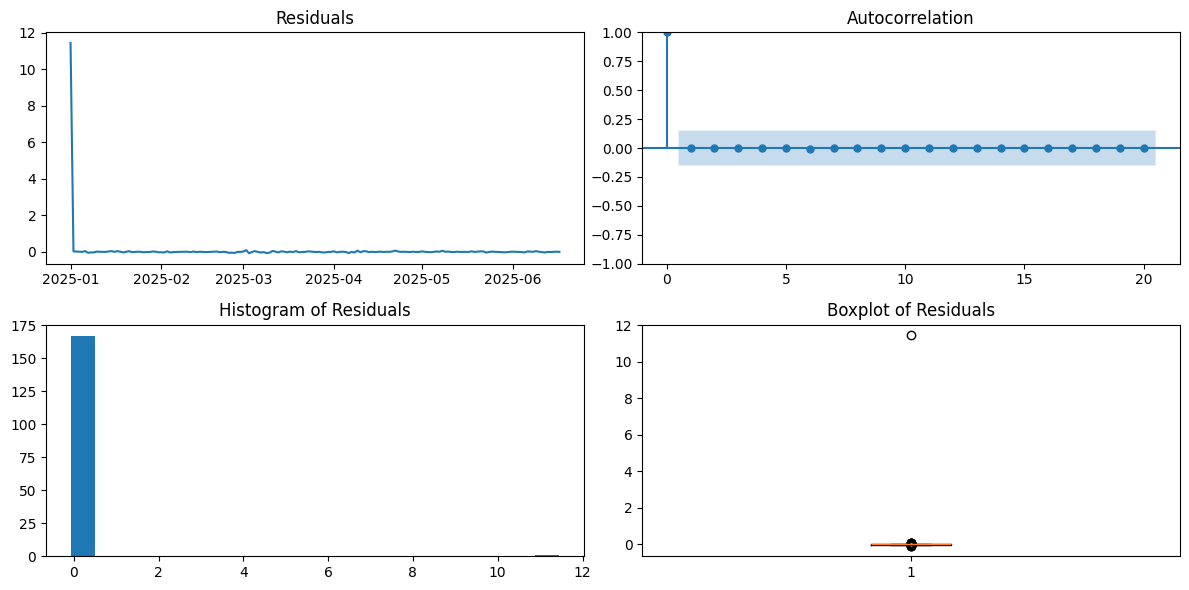

In [49]:
# --- 1. Uji Autokorelasi (Ljung-Box Test) ---
print("Ljung-Box Test (Autokorelasi Residual):")
print(acorr_ljungbox(resid2, lags=[10], return_df=True))

# --- 2. Uji Homoskedastisitas (Ljung-Box kuadrat residual) ---
print("\nLjung-Box Test (Autokorelasi pada residual^2):")
print(acorr_ljungbox(resid2**2, lags=[10], return_df=True))

# --- 3. Uji Normalitas (Jarque-Bera) ---
print("\nJarque-Bera Test (Normalitas Residual):")
jb_stat, jb_pvalue = jarque_bera(resid2)
print(f"JB Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")

# --- 4. Plot Diagnostik ---
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(resid2)
plt.title("Residuals")

plt.subplot(2,2,2)
plot_acf(resid2, ax=plt.gca(), lags=20)

plt.subplot(2,2,3)
plt.hist(resid2, bins=20)
plt.title("Histogram of Residuals")

plt.subplot(2,2,4)
plt.boxplot(resid2)
plt.title("Boxplot of Residuals")

plt.tight_layout()
plt.show()

asumsi  normalitas residual tidak terpenuhi

asumsi autokorelasi dan homoskedastik terpenuhi

model tidak benar-benar layak digunakan

## best model

In [51]:
# cari nilai aic dan bic dari model1 -- model 2
print("AIC Model 1:", fit1.aic)
print("BIC Model 1:", fit1.bic)
print("AIC Model 2:", fit2.aic)
print("BIC Model 2:", fit2.bic)


AIC Model 1: -756.0544449686147
BIC Model 1: -749.8184573437812
AIC Model 2: -755.9914858434109
BIC Model 2: -749.7554982185775


In [52]:
# cari nilai mse dan rmse model 1
# Get the fitted values (predictions) from model1
fitted_values_log = fit1.fittedvalues

# Get the actual log-transformed data that was used for fitting
# The model was fit on the entire log_data series
actual_log_data = log_data

# Ensure they have the same index for comparison (this step might be redundant
# if fitted_values_log already has the same index as log_data, but it's safe)
common_index = fitted_values_log.index.intersection(actual_log_data.index)
fitted_values_log = fitted_values_log[common_index]
actual_log_data = actual_log_data[common_index]

# Calculate MSE and RMSE on the log scale
mse_log = mean_squared_error(actual_log_data, fitted_values_log)
rmse_log = np.sqrt(mse_log)

print(f"MSE (Log Scale) for ARIMA(0,1,1): {mse_log:.6f}")
print(f"RMSE (Log Scale) for ARIMA(0,1,1): {rmse_log:.6f}")

# To calculate on the original scale, you would inverse transform:
fitted_values_original = np.exp(fitted_values_log)
actual_original_data = data_close[common_index]
mse_original = mean_squared_error(actual_original_data, fitted_values_original)
rmse_original = np.sqrt(mse_original)
print(f"MSE (Original Scale) for ARIMA(0,1,1): {mse_original:.2f}")
print(f"RMSE (Original Scale) for ARIMA(0,1,1): {rmse_original:.2f}")

MSE (Log Scale) for ARIMA(0,1,1): 0.781691
RMSE (Log Scale) for ARIMA(0,1,1): 0.884133
MSE (Original Scale) for ARIMA(0,1,1): 58221207.72
RMSE (Original Scale) for ARIMA(0,1,1): 7630.28


## FORECAST 3 HARI KE DEPAN MODEL ARIMA (0,1,1)


In [53]:
# Forecast 3 hari ke depan
forecast_30 = fit1.get_forecast(steps=3)
forecast_mean = forecast_30.predicted_mean
forecast_ci = forecast_30.conf_int()

# Buat indeks tanggal untuk forecast
last_index = data_close.index[-1]
if isinstance(last_index, pd.Timestamp):
    future_dates = pd.date_range(start=last_index + pd.Timedelta(days=1), periods=3)
else:
    # Jika index berupa integer
    future_dates = range(len(data_close), len(data_close) + 3)

forecast_series = pd.Series(forecast_mean, index=future_dates)


# Tampilkan nilai forecast
forecast_df = pd.DataFrame({
    'Tanggal': forecast_series.index,
    'Forecast': forecast_series.values,
    'CI Lower': forecast_ci.iloc[:, 0].values,
    'CI Upper': forecast_ci.iloc[:, 1].values
})
print("\nData Forecast 3 Hari ke Depan:")
print(forecast_df)


Data Forecast 3 Hari ke Depan:
     Tanggal  Forecast   CI Lower   CI Upper
0 2025-06-18  11.57892  11.530211  11.627630
1 2025-06-19  11.57892  11.515418  11.642422
2 2025-06-20  11.57892  11.503472  11.654369


In [54]:
# Transformasi dari log ke asli
forecast_series_exp = np.exp(forecast_series)
ci_lower_exp = np.exp(forecast_ci.iloc[:, 0])
ci_upper_exp = np.exp(forecast_ci.iloc[:, 1])

# Gabungkan jadi DataFrame baru
forecast_exp_df = pd.DataFrame({
    'Tanggal': forecast_series_exp.index,
    'Forecast (Asli)': forecast_series_exp.values,
    'CI Lower (Asli)': ci_lower_exp.values,
    'CI Upper (Asli)': ci_upper_exp.values
})

# Tampilkan
print("\nData Forecast 3 Hari ke Depan (Skala Asli, dengan CI):")
print(forecast_exp_df)



Data Forecast 3 Hari ke Depan (Skala Asli, dengan CI):
     Tanggal  Forecast (Asli)  CI Lower (Asli)  CI Upper (Asli)
0 2025-06-18    106822.127484    101743.601763    112154.147510
1 2025-06-19    106822.127484    100249.594695    113825.566627
2 2025-06-20    106822.127484     99059.116168    115193.506279


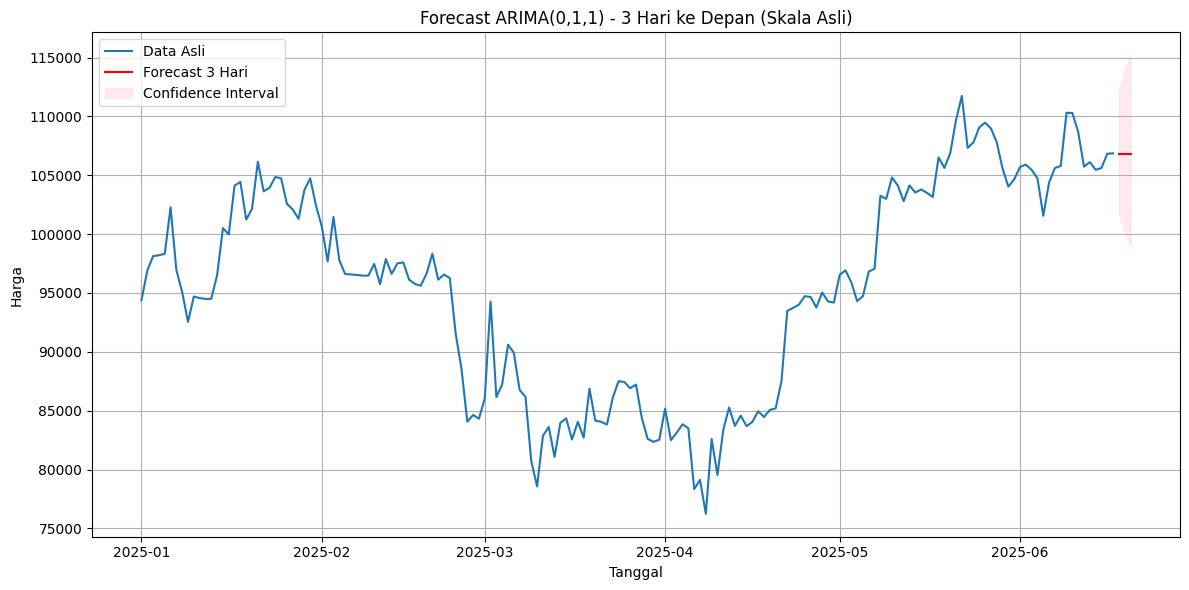

In [55]:

# --- Plot Data Asli dan Forecast ---
plt.figure(figsize=(12, 6))
plt.plot(data_close, label='Data Asli')
# Forecast
plt.plot(forecast_series_exp, label='Forecast 3 Hari', color='red')

# CI dalam skala asli
plt.fill_between(
    forecast_series_exp.index,
    np.exp(forecast_ci.iloc[:, 0]),
    np.exp(forecast_ci.iloc[:, 1]),
    color='pink', alpha=0.3, label='Confidence Interval'
)

plt.title('Forecast ARIMA(0,1,1) - 3 Hari ke Depan (Skala Asli)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


# PERBANDINGAN


In [56]:
# Ubah nama kolom Date di future_df agar sama dengan forecast_exp_df
future_df.rename(columns={'Date': 'Tanggal'}, inplace=True)

# Gabungkan berdasarkan tanggal
combined_df = pd.merge(future_df, forecast_exp_df, on='Tanggal', how='inner')

# Tampilkan hasil gabungan
print("\nGabungan Prediksi LSTM dan ARIMA (3 Hari ke Depan):")
print(combined_df.to_string(index=False))



Gabungan Prediksi LSTM dan ARIMA (3 Hari ke Depan):
   Tanggal  Predicted_Close_Price_USD  Forecast (Asli)  CI Lower (Asli)  CI Upper (Asli)
2025-06-18              107519.929688    106822.127484    101743.601763    112154.147510
2025-06-19              107560.789062    106822.127484    100249.594695    113825.566627
2025-06-20              107616.625000    106822.127484     99059.116168    115193.506279


In [63]:
# Ambil 7 hari terakhir dari data aktual
history_df = daily_data[['Close']].reset_index()
history_df.rename(columns={'Close': 'Harga Aktual', 'index': 'Tanggal'}, inplace=True)

# Gabungkan semuanya: data historis + prediksi
visual_df = pd.concat([history_df.tail(7), combined_df], ignore_index=True)


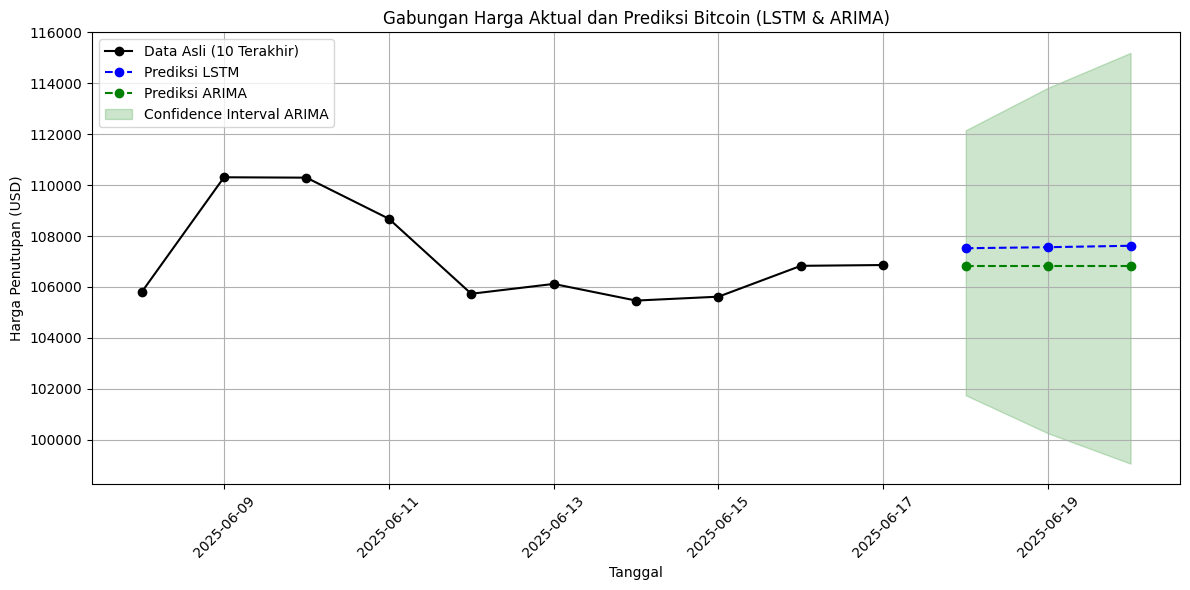

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(data_close.tail(10), label='Data Asli (10 Terakhir)', color='black', marker='o')

# Garis prediksi LSTM
plt.plot(combined_df['Tanggal'], combined_df['Predicted_Close_Price_USD'],
         label='Prediksi LSTM', color='blue', linestyle='--', marker='o')

# Garis prediksi ARIMA
plt.plot(combined_df['Tanggal'], combined_df['Forecast (Asli)'],
         label='Prediksi ARIMA', color='green', linestyle='--', marker='o')

# Confidence Interval ARIMA
plt.fill_between(combined_df['Tanggal'],
                 combined_df['CI Lower (Asli)'],
                 combined_df['CI Upper (Asli)'],
                 color='green', alpha=0.2, label='Confidence Interval ARIMA')

# Tampilan
plt.title('Gabungan Harga Aktual dan Prediksi Bitcoin (LSTM & ARIMA)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
